# Approximation of Generalization Error

The objective of this tutorial is to learn the function

$$u = sin(x), \quad x\in(0, 2\pi)$$

by using feed-forward dense neural networks and define a *computable metric* that best approximate the generalization error, This metric  has be computed only from the available data. Recall that in practice we do not have access to the generalization error.

This is also useful for the selection of the model parameters and therefore we also refer to this metric as **selection criterion**. We choose the network hyperparameters, suc as number of hidden layers, number of neurons, regularization parameter etc., in the following way: We train the model for each configuration and compute the selection criterion. Then, the configuration that minimizes the selection criterion is picked (this procedure is also called **ensemble training**) Indeed, we would like that this configuration also minimizes the generalization error. That's why we are interested in defining a good selection crtioerion. 

Here, we will discuss for different values of the noise level ($\sigma=0$ and $\sigma=0.25$) two of them :
- training error
- validation error

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import KFold
mpl.rcParams['figure.dpi']= 300

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Define the exact solution
def exact_solution(x):
    return torch.sin(x)

$\mathbf{\text{Step 1: Dataset Generation}}$

We are going to use the training set 

$$S=\{ (x_i, u_i), ~i=1,...,n \}$$ 

with 

$$x_i \sim U\big(0, 2\pi\big), \quad u_i \sim N\big(sin(x_i), \sigma\big).$$

Here, $U(a,b)$ is a uniform random distribution between $a$ and $b$, and $N(\mu, \sigma)$ is a normal distribution with mean $\mu$ and standard deviation $\sigma$

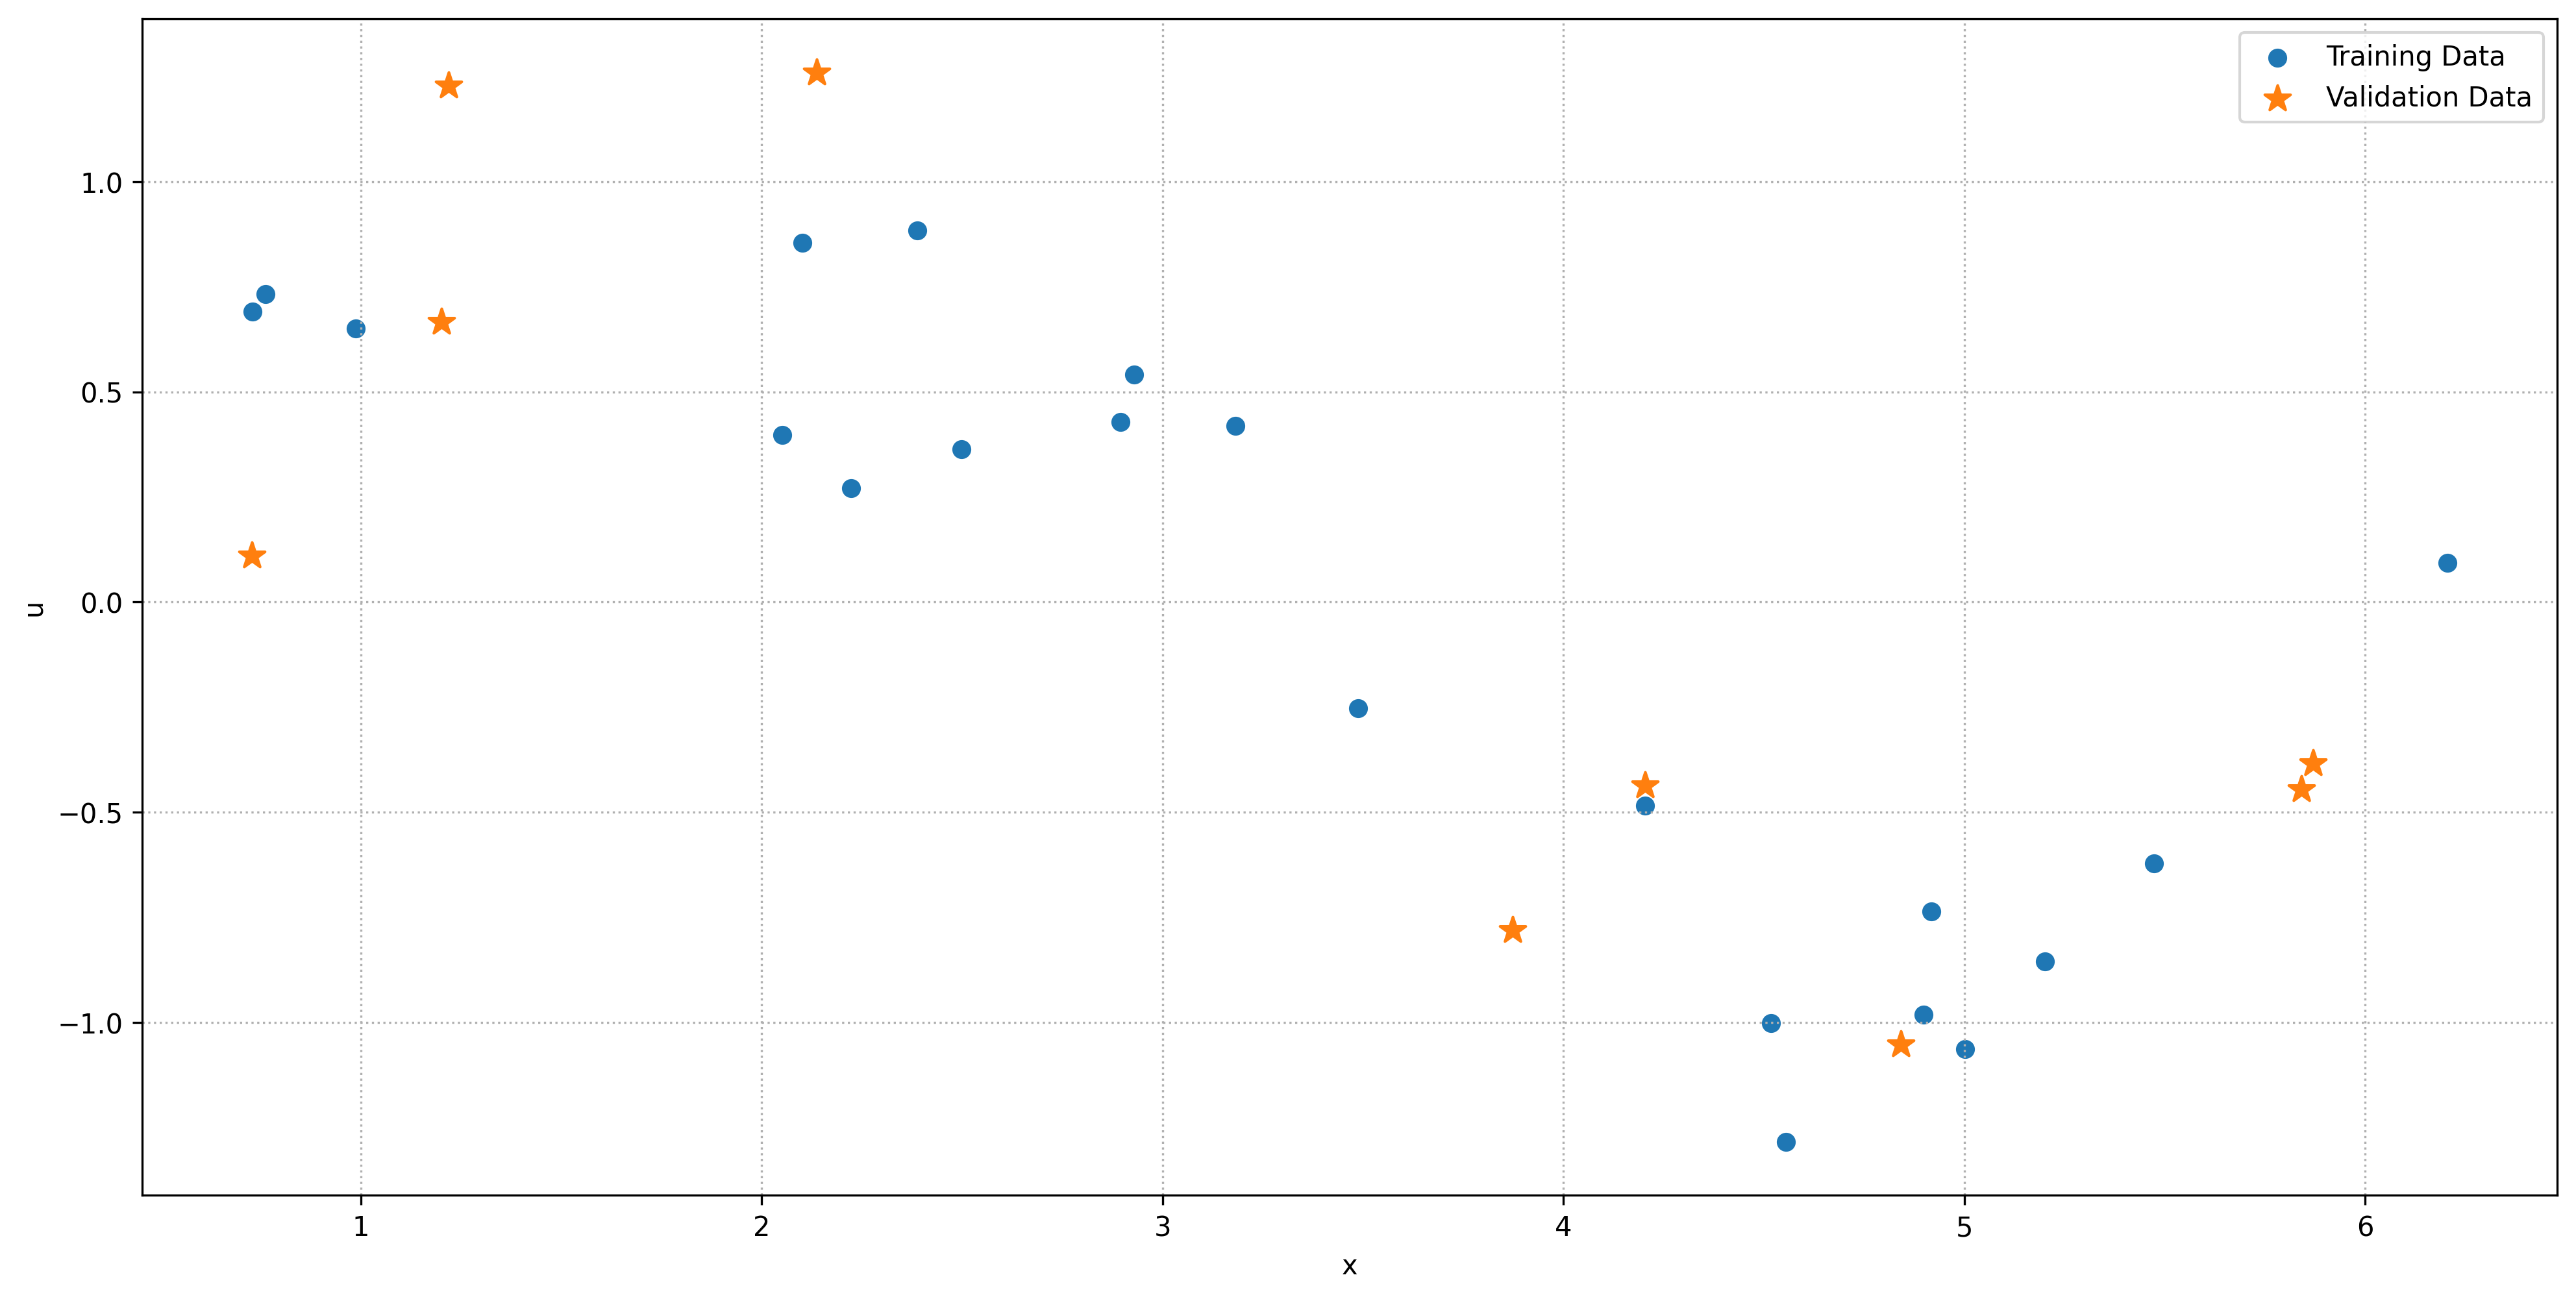

In [4]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "ADAM"
# Random Seed for dataset generation
sampling_seed = 78
torch.manual_seed(sampling_seed)

# Number of training samples
n_samples = 30
# Noise level
sigma = 0.25

x = 2*np.pi*torch.rand((n_samples, 1))
y = exact_solution(x) + sigma*torch.randn(x.shape)


validation_size = int(30*x.shape[0]/100)
training_size = x.shape[0] - validation_size
x_train = x[:training_size,:]
y_train = y[:training_size,:]
    
x_val = x[training_size:,:]
y_val = y[training_size:,:]


batch_size = n_samples
training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.scatter(x_train,y_train, label="Training Data")
plt.scatter(x_val,y_val, marker="*", s=100, label="Validation Data")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

$\mathbf{\text{Step 2: Model Generation}}$

In [5]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        
        # Random Seed for weight initialization
        self.retrain = 128
        # Xavier weight initialization
        self.init_xavier()

        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers-1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)
            
    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)
    
    def init_xavier(self):
        torch.manual_seed(self.retrain)
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                #torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)
        self.apply(init_weights)


In [6]:
# Model definition
my_network = NeuralNet(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)

$\mathbf{\text{Step 3: Model Training}}$

In [7]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.0001, weight_decay=0)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [8]:
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean(abs(u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()/ len(training_set)
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, ))**p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)
        
        if verbose:
            print('Training Loss: ', np.round(running_loss[0],8))
            print('Validation Loss: ', np.round(validation_loss,8))
            
    print('Final Training Loss: ', np.round(history[0][-1],8))
    print('Final Validation Loss: ', np.round(history[1][-1],8))
    return history


In [9]:
n_epochs = 25000
history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False )

Final Training Loss:  1e-05
Final Validation Loss:  0.26919788


$\mathbf{\text{Step 3: Model Evaluation}}$

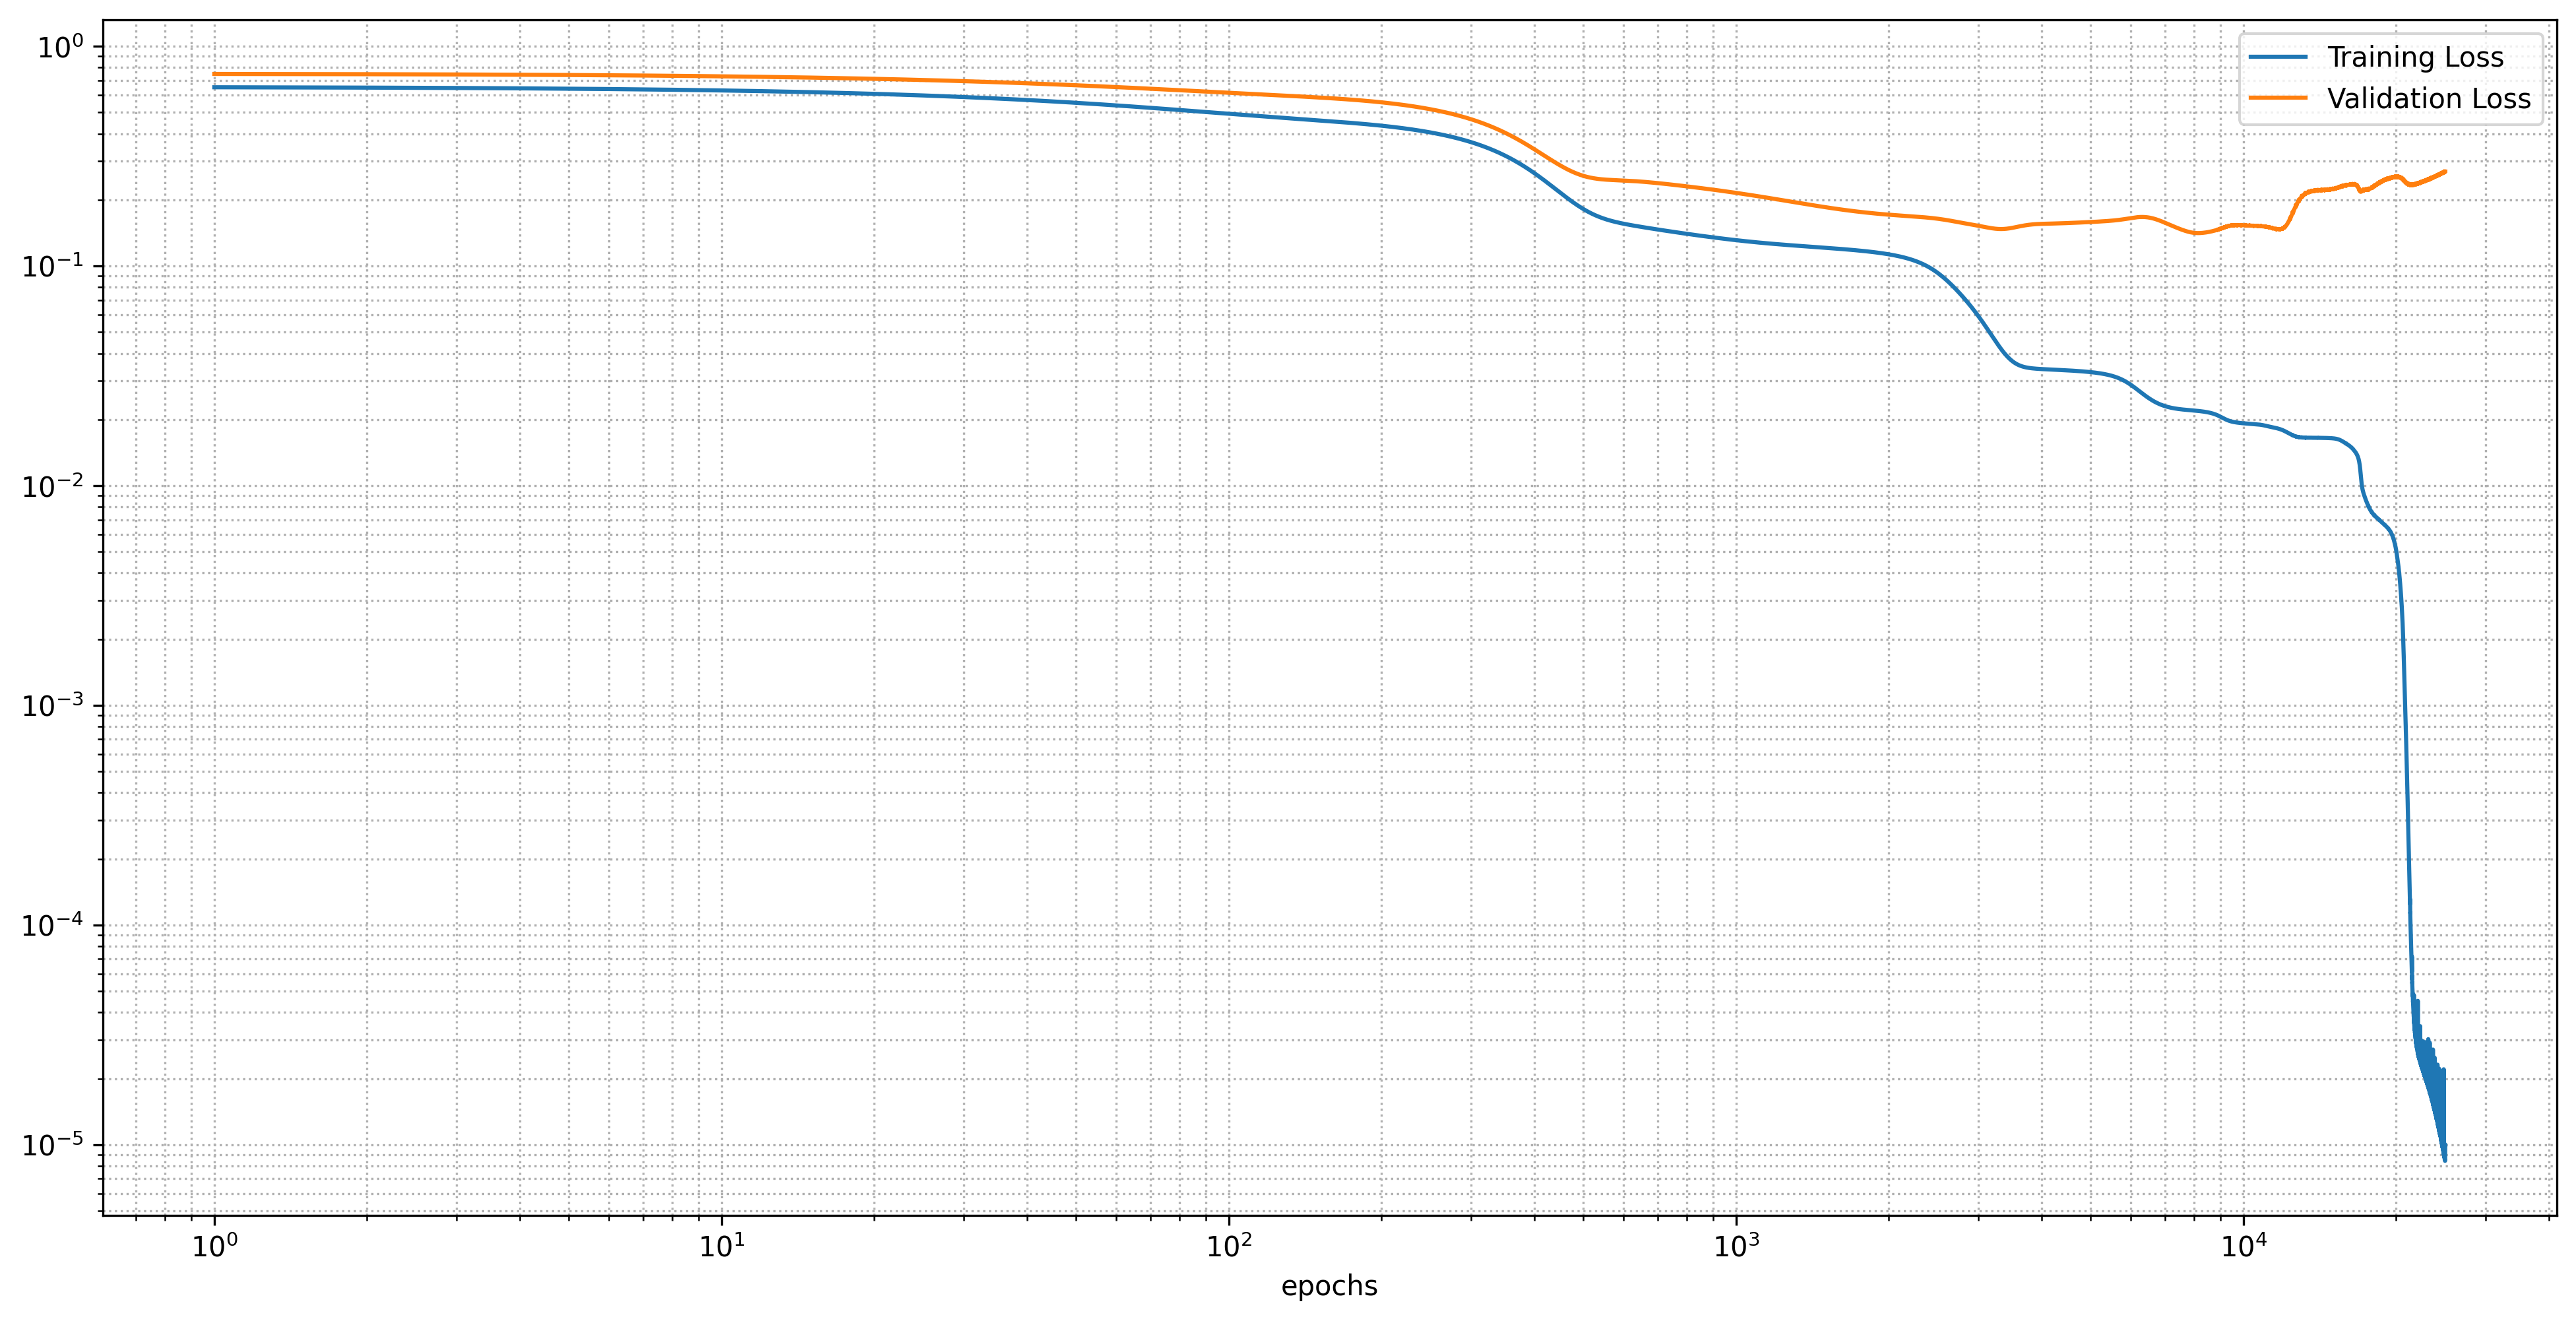

In [10]:
plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), history[0], label="Training Loss")
plt.plot(np.arange(1,n_epochs+1), history[1], label="Validation Loss")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epochs")
plt.legend()

In [11]:
x_test = torch.linspace(0, 2*np.pi, 10000).reshape(-1,1)
y_test = exact_solution(x_test).reshape(-1,)
y_val = y_val.reshape(-1,)
y_train = y_train.reshape(-1,)

In [12]:
y_test_pred = my_network(x_test).reshape(-1,)
y_val_pred = my_network(x_val).reshape(-1,)
y_train_pred = my_network(x_train).reshape(-1,)

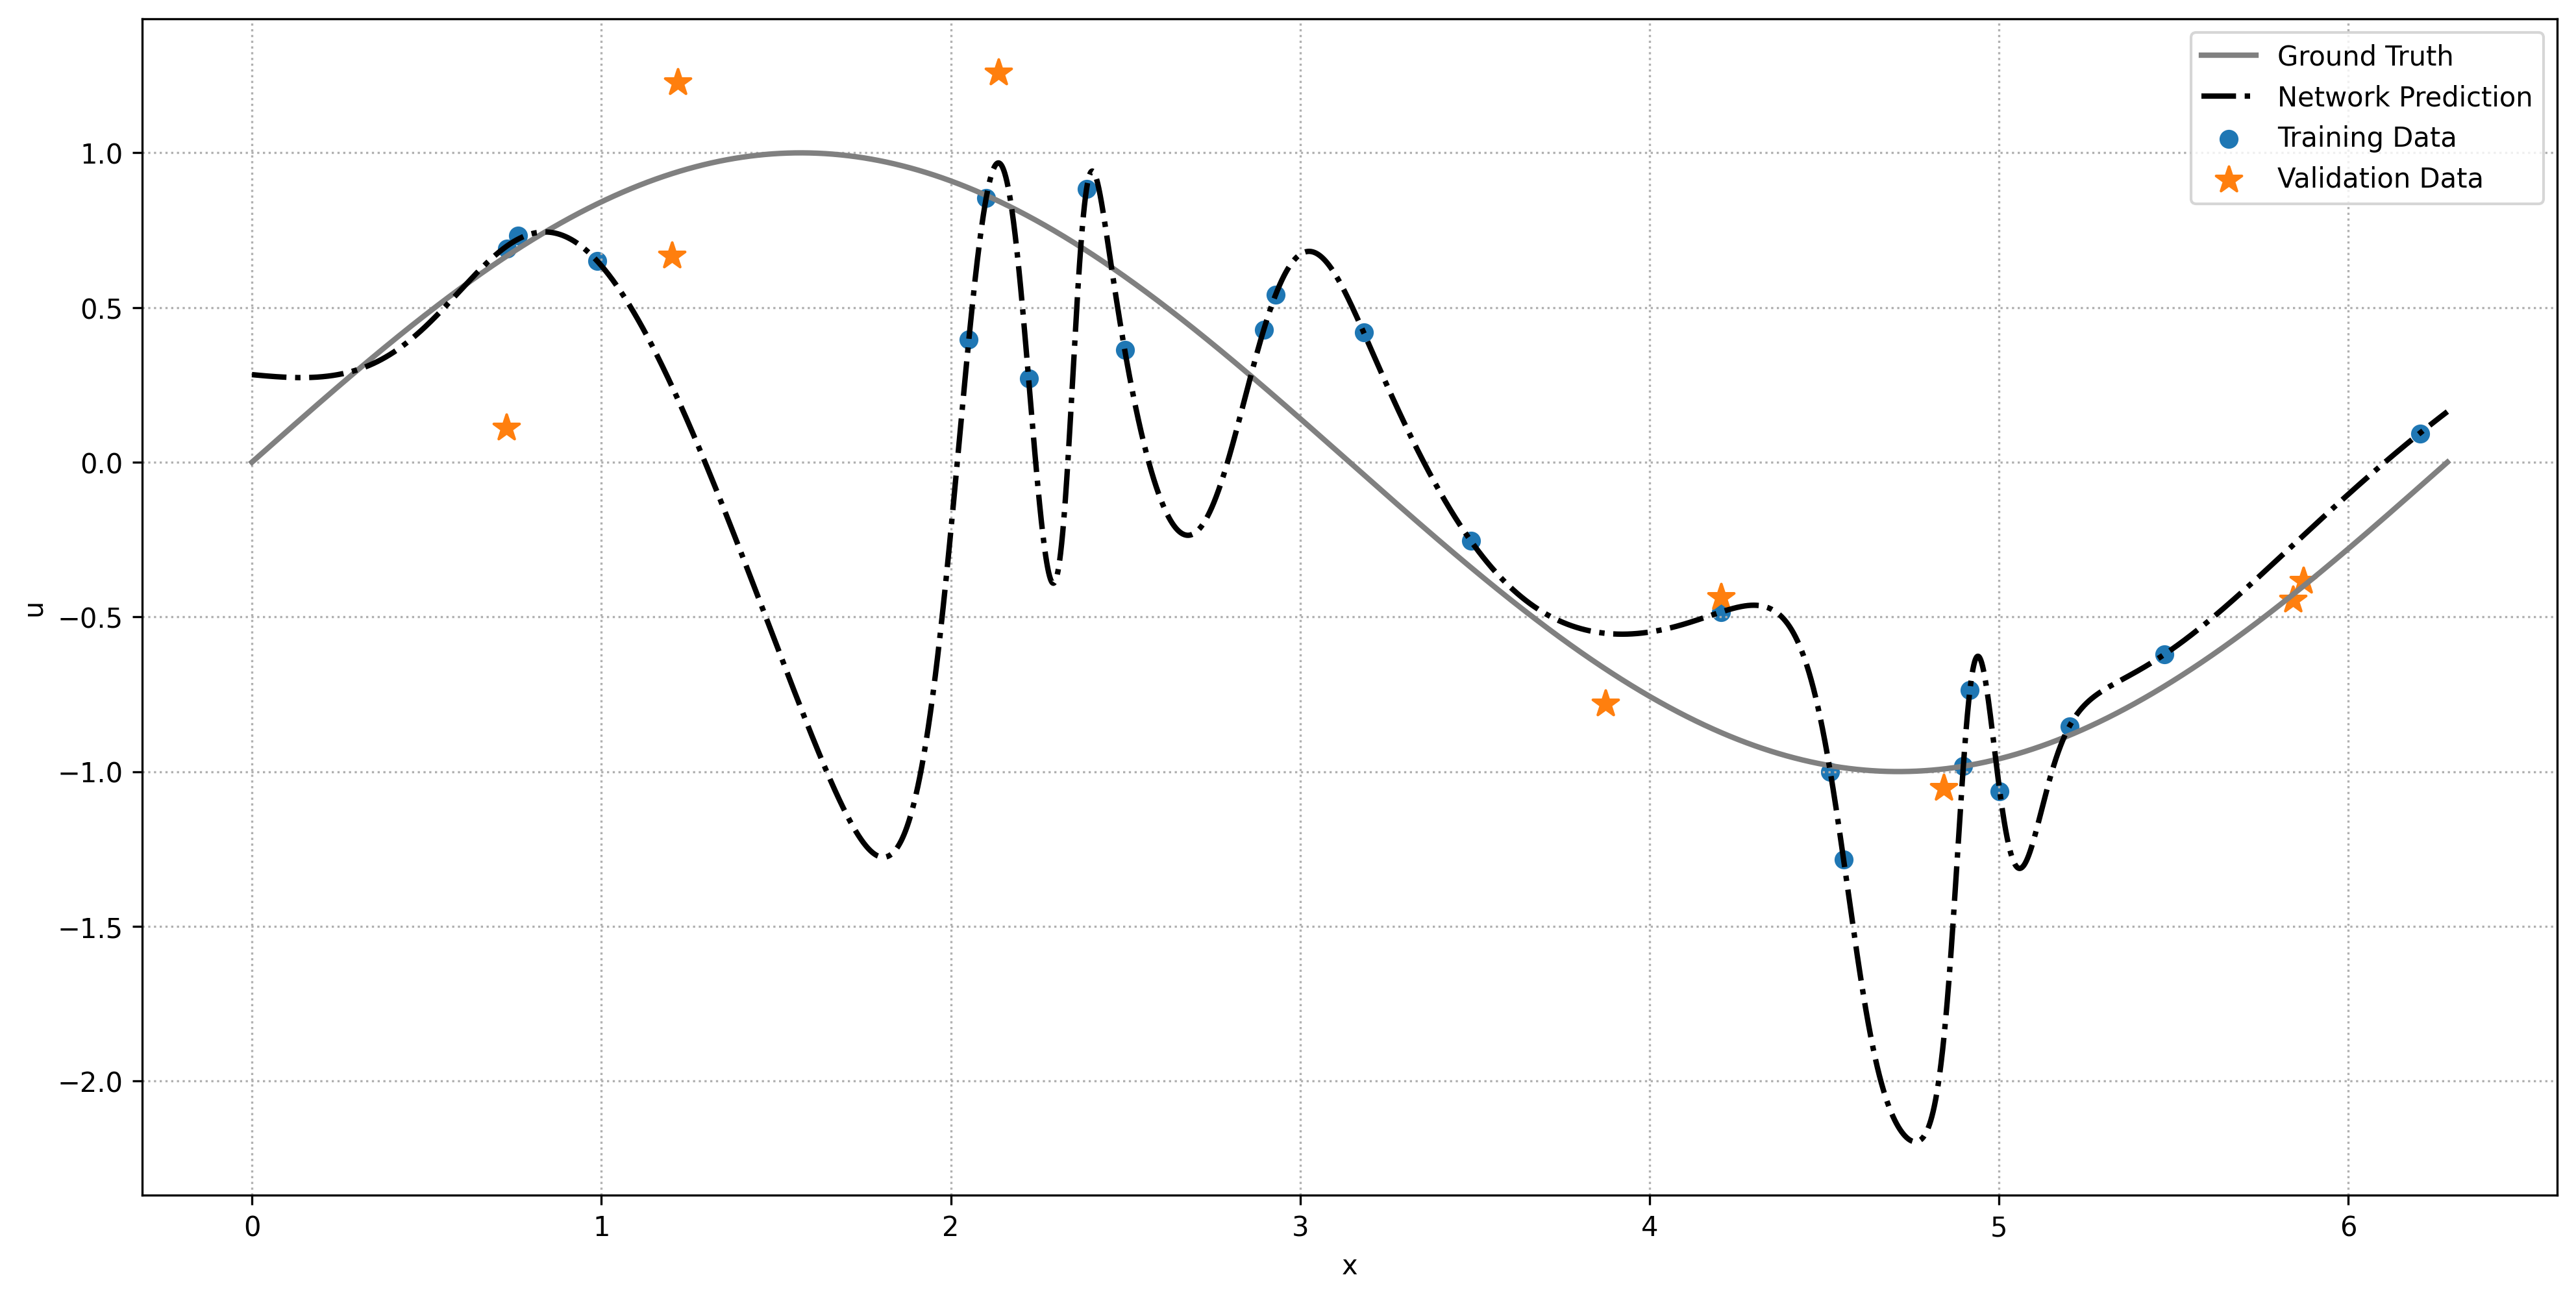

In [13]:
plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.scatter(x_train, y_train, label="Training Data", marker="o", color="C0")
plt.scatter(x_val, y_val, label="Validation Data", marker="*", color="C1", s=100)
plt.plot(x_test, y_test, label="Ground Truth",lw=2, color="grey")
plt.plot(x_test, y_test_pred.detach(), label="Network Prediction",lw=2, color="black", ls="-.")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [14]:
# Compute the relative validation error
relative_error_train = torch.mean((y_train_pred - y_train)**2)/torch.mean(y_train**2)
print("Relative Training Error: ", relative_error_train.detach().numpy()**0.5*100, "%")

# Compute the relative validation error
relative_error_val = torch.mean((y_val_pred - y_val)**2)/torch.mean(y_val**2)
print("Relative Validation Error: ", relative_error_val.detach().numpy()**0.5*100, "%")

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((y_test_pred - y_test)**2)/torch.mean(y_test**2)
print("Relative Testing Error: ", relative_error_test.detach().numpy()**0.5*100, "%")

Relative Training Error:  0.43883160687983036 %
Relative Validation Error:  64.58415985107422 %
Relative Testing Error:  100.15959739685059 %


### Exercises

1. Given the small size of the the validation set, the validation error is usually affected by high variance. In order to reduce its variance, in machine learning *K-fold cross validaton* is commonly adopted. This procedure can be performed as follows:
    1. Divide the dataset $S$ into K non-overlapping subset $S_j$, $j=1,...,K$
    2. For each subset $S_j$:
        1. Train the model on $U_{i\neq j}S_i$
        2. Compute the validation error $e_j$ on the subset $S_j$
    3. Compute the overall average validation by averaging the validation errors $e_j$


In [15]:
kf = KFold(n_splits=10)
n_split = kf.get_n_splits(x)



average_train_error = 0.
average_validation_error = 0.
average_testing_error = 0.

for k, (train_index, test_index) in enumerate(kf.split(x)):
    print("#################################")
    print("Running fold number ", k)
    # Split between training and validation data
    x_train_k, x_val_k = x[train_index], x[test_index]
    y_train_k, y_val_k = y[train_index], y[test_index]
    batch_size = x_train_k.shape[0]
    
    # Define the neural network
    my_network_k = NeuralNet(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)
    
    
    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network_k.parameters(), lr=0.0001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network_k.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    training_set_k = DataLoader(torch.utils.data.TensorDataset(x_train_k, y_train_k), batch_size=batch_size, shuffle=True)
    
    # Train the model
    history = fit(my_network_k, training_set_k, x_val_k, y_val_k, n_epochs, optimizer_, p=2, verbose=False )
    
    # Compute network prediction
    y_val_pred = my_network_k(x_val_k)
    y_train_pred = my_network_k(x_train_k)
    y_test_pred = my_network(x_test)
    
    # Evaulate network performance
    relative_error_train = torch.mean((y_train_pred.reshape(-1,) - y_train_k.reshape(-1,))**2)/torch.mean(y_train.reshape(-1,)**2)
    relative_error_val = torch.mean((y_val_pred.reshape(-1,) - y_val_k.reshape(-1,))**2)/torch.mean(y_val.reshape(-1,)**2)
    relative_error_test = torch.mean((y_test_pred.reshape(-1,) - y_test.reshape(-1,))**2)/torch.mean(y_test.reshape(-1,)**2)
    
    # Compute average network performance
    average_train_error = average_train_error + relative_error_train.item()**0.5/n_split
    average_validation_error = average_validation_error +  relative_error_val.item()**0.5/n_split
    average_testing_error = average_testing_error +  relative_error_test.item()**0.5/n_split
    

#################################
Running fold number  0
Final Training Loss:  0.02823937
Final Validation Loss:  0.50966352
#################################
Running fold number  1
Final Training Loss:  0.04418844
Final Validation Loss:  0.02966023
#################################
Running fold number  2
Final Training Loss:  6.909e-05
Final Validation Loss:  1.41293097
#################################
Running fold number  3
Final Training Loss:  0.03949491
Final Validation Loss:  0.10362655
#################################
Running fold number  4
Final Training Loss:  0.03076312
Final Validation Loss:  0.15999541
#################################
Running fold number  5
Final Training Loss:  0.03808901
Final Validation Loss:  0.04805742
#################################
Running fold number  6
Final Training Loss:  0.04133133
Final Validation Loss:  0.10412395
#################################
Running fold number  7
Final Training Loss:  0.00585858
Final Validation Loss:  0.22871695
#

In [16]:
print("Relative Average Training Error: ", average_train_error*100, "%")
print("Relative Average Validation Error: ", average_validation_error*100, "%")
print("Relative Average Testing Error: ", average_testing_error*100, "%")

Relative Average Training Error:  20.939227778029895 %
Relative Average Validation Error:  58.65336437920814 %
Relative Average Testing Error:  100.15960116441069 %
